## Language Level Classification

----

Project: Language Level Analysis and Classification <br>
Seminar *Educational Assessment for Language Technology* <br>
WS 2015/16, Magdalena Wolska


Julia Suter, January 2018

----
Language_Level_Classification.ipynb

- train, test and evaluate language level classifier on different versions and datasets
- principal component analysis
- paramter screening
- extraction of classifier coefficients
- visualize features before and after scaling, PCA, confusion matrix for prediction and ground truth, and feature relevance

### Import Statements

In [1]:
# Import Statements
import os
import sklearn
from sklearn import svm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from warnings import simplefilter
simplefilter('ignore', FutureWarning)

import scipy

### Load features and names

#### Settings

In [2]:
version = 'default'
#version = 'default_nopara'
#version = 'non_linear_svc_rbf'

# use literary texts from Gutenberg instead of Language Levels
literature_version = False

baseline = False
version = 'baseline' if baseline else version

# get data dir
data_dir = '../3_Text_features/Features/'
#data_dir = '../3_Text_features/Features_truncated_beginning/'
#data_dir = '../3_Text_features/Features_truncated_middle/'
#data_dir = '../3_Text_features/Features_5sents_chunks/'

if literature_version:
    data_dir = '../3_Text_features/Literature_Features/'
    #data_dir = '../3_Text_features/Literature_Features_short/'
    
para_screening = False

# constants
RANDOM_STATE = 41
TRAIN_SIZE = 0.9
NUMBER_OF_FEATURES = None
MIN_N_WORDS = 0
MIN_N_SENTS = 3

# use different training size for literature set
if literature_version:
    TRAIN_SIZE = 0.8
    
print('Settings\n-----------')
print('Version: {}'.format(version))
print('Baseline: {}'.format(baseline))
print('Data from: {}'.format(data_dir[18:]))

Settings
-----------
Version: default
Baseline: False
Data from: /Literature_Features/


#### Get features

In [3]:
# for assigning labels
#label_dict = {0:'A1',1:'B1',2:'B2',3:'A2'}

# collect data
all_feature_arrays = []
solutions = []
all_sents_n = []

total_files_original = 0

# for each dir in [A1,A2,B1,B2] or authors
for i, directory in enumerate(os.listdir(data_dir)):

    # get number of files
    all_files = os.listdir(data_dir+directory) 
    total_files_original += len(all_files)

    # get number of features for feature array
    if baseline:
        NUMBER_OF_FEATURES = 2
    else:
        sample_file = all_files[0]
        df = pd.read_csv(data_dir+directory+'/'+sample_file)
        array = np.array(df)        
        NUMBER_OF_FEATURES = array.shape[0]-4
   
    # set feature array
    feature_array = np.zeros((len(all_files), NUMBER_OF_FEATURES))

    # for each file in subfolder
    for j, file in enumerate(all_files):

        # read data in pandas df (just for fun)
        df = pd.read_csv(data_dir+directory+'/'+file)

        # transform into array
        array = np.array(df)

        # get values and names
        features = array[:,1]         
        feature_names = array[:,0]
        
        # get number of words and sents
        n_words = features[2]
        n_sents = features[3]
        
        all_sents_n.append(n_sents)
        
        # FILTERING if needed
        if n_words < MIN_N_WORDS:
            print('filtered')
            continue
        if n_sents < MIN_N_SENTS:
            print('filtered')
            continue
            
        # get all features (except words per sent and LIX; opposite if baseline)
        # n_sents, n_words is never used
        features = features[:2] if baseline else features[4:]
        feature_names = feature_names[:2] if baseline else feature_names[4:]

        # save features in array
        feature_array[j] = features
        
        
    # if FILTERING remove empty rows
    feature_array = feature_array[~(feature_array==0).all(1)]

    # add correct label to solution dict (x times; x = number of samples)
    solutions.extend([directory]*feature_array.shape[0]) 
    
    # append feature array 
    all_feature_arrays.append(feature_array)

    
# concatenate feature arrays
feature_array = np.concatenate(all_feature_arrays)

# transform solution array
solution_array = np.array(solutions)            

# print sample and feature count
print('# samples: {}'.format(feature_array.shape[0]))
print('# features: {}'.format(feature_array.shape[1]))

# how many were filtered out
print('# filtered out docs: {}'.format(total_files_original-feature_array.shape[0]))

# samples: 7365
# features: 80
# filtered out docs: 0


### Plot features before and after scaling

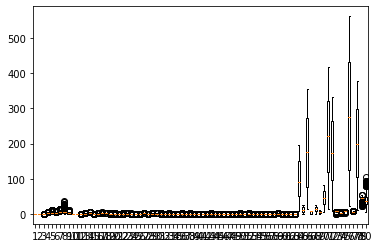

In [4]:
# Plot features before scaling
plt.boxplot(feature_array)
plt.show()

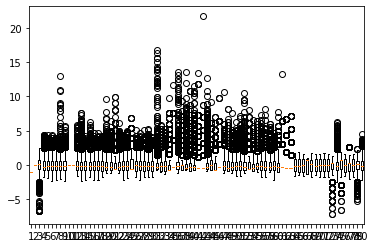

In [5]:
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
feature_array = scaler.fit_transform(feature_array)

# Plot features after scaling
plt.boxplot(feature_array)
plt.show()

### Prinicipal Component Analysis

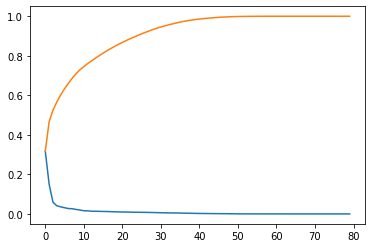

In [6]:
# source: https://www.youtube.com/watch?v=SBYdqlLgbGk

def doPCA():
    """Get PCA for feature array."""
    from sklearn.decomposition import PCA
    pca = PCA()   #n_components=2)  # default -> max: number of features
    pca.fit(feature_array)
    return pca

# first two principal components
pca = doPCA()
first_pc  =  pca.components_[0]
second_pc =  pca.components_[1]

# transform data
transformed_data = pca.transform(feature_array)

if not literature_version:
    # axis of pc1, pc2
    for i,j in zip(transformed_data, feature_array):
        plt.scatter(first_pc[0]*i[0], first_pc[1]*i[0], color='r')
        plt.scatter(second_pc[0]*i[1], second_pc[1]*i[1], color='c')
        plt.scatter(j[0],j[1], color='b')

    plt.show()

    # prinicipal component space (pc1, pc2)
    target_colors = {'A1':'blue','A2':'green','B1':'orange','B2':'red'}
    plt.scatter(transformed_data[:,0],transformed_data[:,1], 
                c=[target_colors[key] for key in solution_array],
                alpha=0.5, edgecolor='none')
    plt.show()

# if you want to use transformed data
#feature_array = transformed_data

# explained variance ratio (how much is covered by how many components)

# per component
plt.plot(pca.explained_variance_ratio_)
# cumulative
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

### Data splitting and classifier training

In [7]:
# split into training and test data
f_train, f_test, s_train, s_test = sklearn.model_selection.train_test_split(feature_array, solution_array,
                                                                             train_size=TRAIN_SIZE,
                                                                             stratify=solution_array,
                                                                             random_state=RANDOM_STATE)

# Check if order of labels is correct, and number of samples per classes
print(np.unique(s_train,return_counts=True)[0])
print(np.unique(s_train,return_counts=True)[1])
print(np.unique(s_test, return_counts=True)[0])
print(np.unique(s_test, return_counts=True)[1])

labels = np.unique(s_train,return_counts=True)[0]

['BIE' 'DAUT' 'FON' 'GANG' 'GER' 'GRI' 'GTTH' 'HOFF' 'JEA' 'KEL' 'MAY'
 'RAA' 'SCHE' 'SCHN' 'SCHW' 'SPY' 'STO' 'TCK' 'THO' 'ZW']
[302 124 745 221 235 177 146 244 386 150 501 522 238 356 213 166 284 150
 386 346]
['BIE' 'DAUT' 'FON' 'GANG' 'GER' 'GRI' 'GTTH' 'HOFF' 'JEA' 'KEL' 'MAY'
 'RAA' 'SCHE' 'SCHN' 'SCHW' 'SPY' 'STO' 'TCK' 'THO' 'ZW']
[ 75  31 186  56  59  45  37  61  96  37 125 131  59  89  53  42  71  38
  96  86]


In [8]:
# train classifier
classifier = svm.LinearSVC(random_state=RANDOM_STATE,tol=0.1, C=0.6)
classifier.fit(f_train, s_train)

# predict train and test set
pred_train = classifier.predict(f_train)
pred_test = classifier.predict(f_test)

# confusion matrix info
cm_train = sklearn.metrics.confusion_matrix(s_train, pred_train,labels=labels)
cm_test = sklearn.metrics.confusion_matrix(s_test, pred_test, labels=labels)

### Confusion matrix for prediction and ground truth

In [9]:
if literature_version:

    # Author abbreviation dict
    author_dict = {'KA':'Kafka',
                   'KL':'Kleist',
                   'SCHN':'Schnitzler',
                   'ZW':'Zweig',
                   'HOFF':'Hoffmann',
                   
                   'TWA':'Twain', 
                   'TCK':'Tieck', 
                   'GTTH':'Gotthelf',
                   'EICH':'Eichendorff',
                   'KEL':'Keller',
                   
                   'SPY':'Spyri', 
                   'BIE':'Bierbaum',
                   'DAUT':'Dauthendey',
                   'FON':'Fontane',
                   'GANG':'Ganghofer', 
                   
                   'GER':'Gerstäcker',
                   'GRI':'Grimm',
                   'HALT':'Haltrich',
                   'HEB':'Hebbel', 
                   'JEA':'Jean Paul',
                   
                   'MAY':'May',
                   'POE':'Poe',
                   'RAA':'Raabe',
                   'SCHE':'Scheerbart',
                   'SCHW':'Schwab',
                   
                   'STI':'Stifter',
                   'STO':'Storm',
                   'THO':'Thoma'}

    labels = [author_dict[label] for label in labels]

<Figure size 720x720 with 0 Axes>

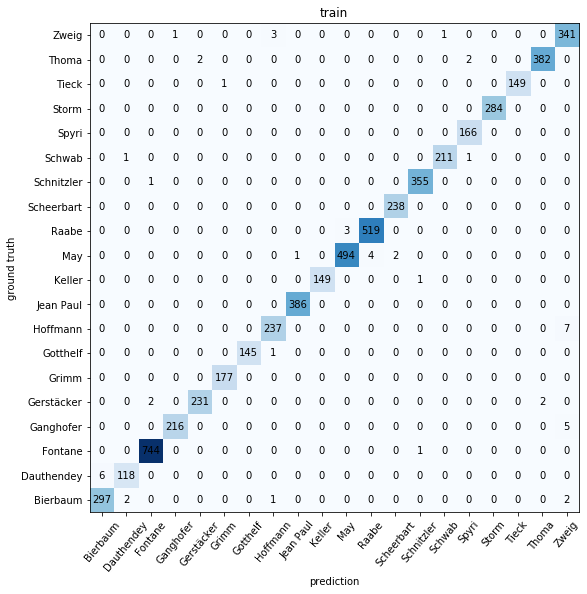

<Figure size 720x720 with 0 Axes>

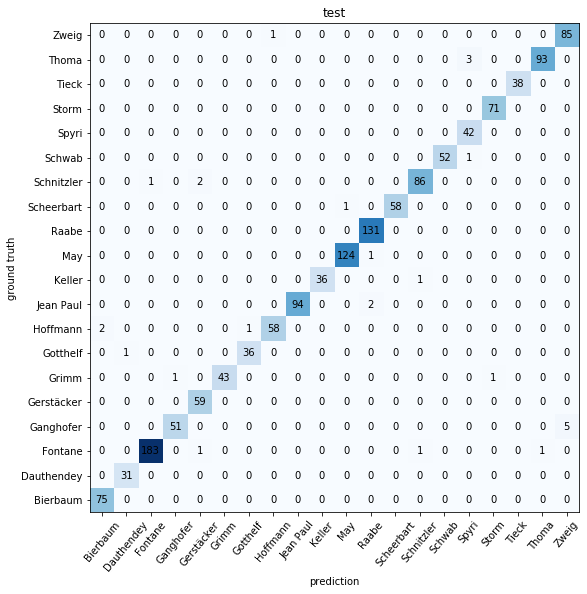

In [10]:
# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    """Plot confusion matrix for classifier"""
    
    if literature_version:
        plt.figure(figsize=(10,10))
    
    plt.figure(figsize=(9,9))

    plt.imshow(cm, interpolation='none',cmap='Blues')
    for (i,j), z in np.ndenumerate(cm):
        plt.text(j, i, z, ha='center', va='center')
        
    plt.xlabel("prediction")
    plt.ylabel("ground truth")
    plt.title(title)
    plt.gca().set_xticks(range(len(labels)))
    plt.gca().set_xticklabels(labels, rotation=50)
    plt.gca().set_yticks(range(len(labels)))
    plt.gca().set_yticklabels(labels)
    plt.gca().invert_yaxis()
    
   
    plt.show()

# Plotting
plot_confusion_matrix(cm_train, 'train')
plot_confusion_matrix(cm_test, 'test')

In [11]:
# Printing Scores
print('Accuracy: {}'.format(sklearn.metrics.accuracy_score(s_test, pred_test)))

Accuracy: 0.9816700610997964


### Classifier coefficients

Coefficients for feature "modal":
[[ 4.82881171]
 [ 1.40595962]
 [ 1.9963837 ]
 [-3.06177097]
 [-1.25831788]
 [-0.54767374]
 [ 0.45381075]
 [-1.45080535]
 [ 0.73877394]
 [ 0.65277309]
 [-0.28675505]
 [-1.67619579]
 [ 0.23805321]
 [ 1.00670554]
 [ 2.37108952]
 [-0.61209191]
 [-0.19210863]
 [ 1.83454802]
 [-3.03587143]
 [-8.00003332]]


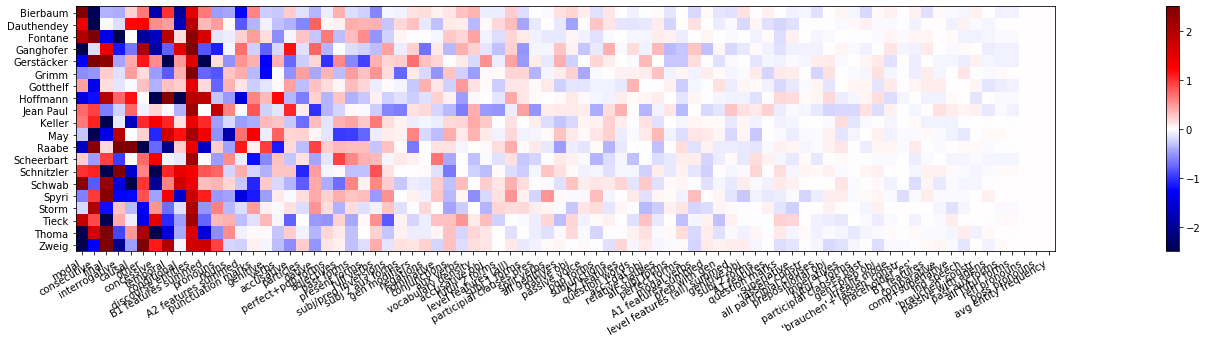

In [12]:
if not baseline:

    # Classifier coefficients
    
    # Example for feature "modal"
    print('Coefficients for feature "modal":')
    print(classifier.coef_[:,feature_names == 'modal'])

    # sorted indices (feature with highest coefficients first)
    sort_idx = np.argsort(-abs(classifier.coef_).max(axis=0))

    # get sorted coefficients and feature names
    sorted_coef = classifier.coef_[:,sort_idx]
    sorted_fnames = feature_names[sort_idx]

    # plot feature coefficients
    x_fig = plt.figure(figsize=(40,5))
    plt.imshow(sorted_coef, interpolation='none', cmap='seismic',vmin=-2.5, vmax=2.5)
    plt.colorbar()
    
    # set ticks and lbabels
    plt.gca().set_yticks(range(len(labels)))
    plt.gca().set_yticklabels(labels)

    plt.gca().set_xticks(range(len(feature_names)))
    plt.gca().set_xticklabels(sorted_fnames)

    x_fig.autofmt_xdate()
    plt.show()
    

#### Classifier coefficients displayed on two lines

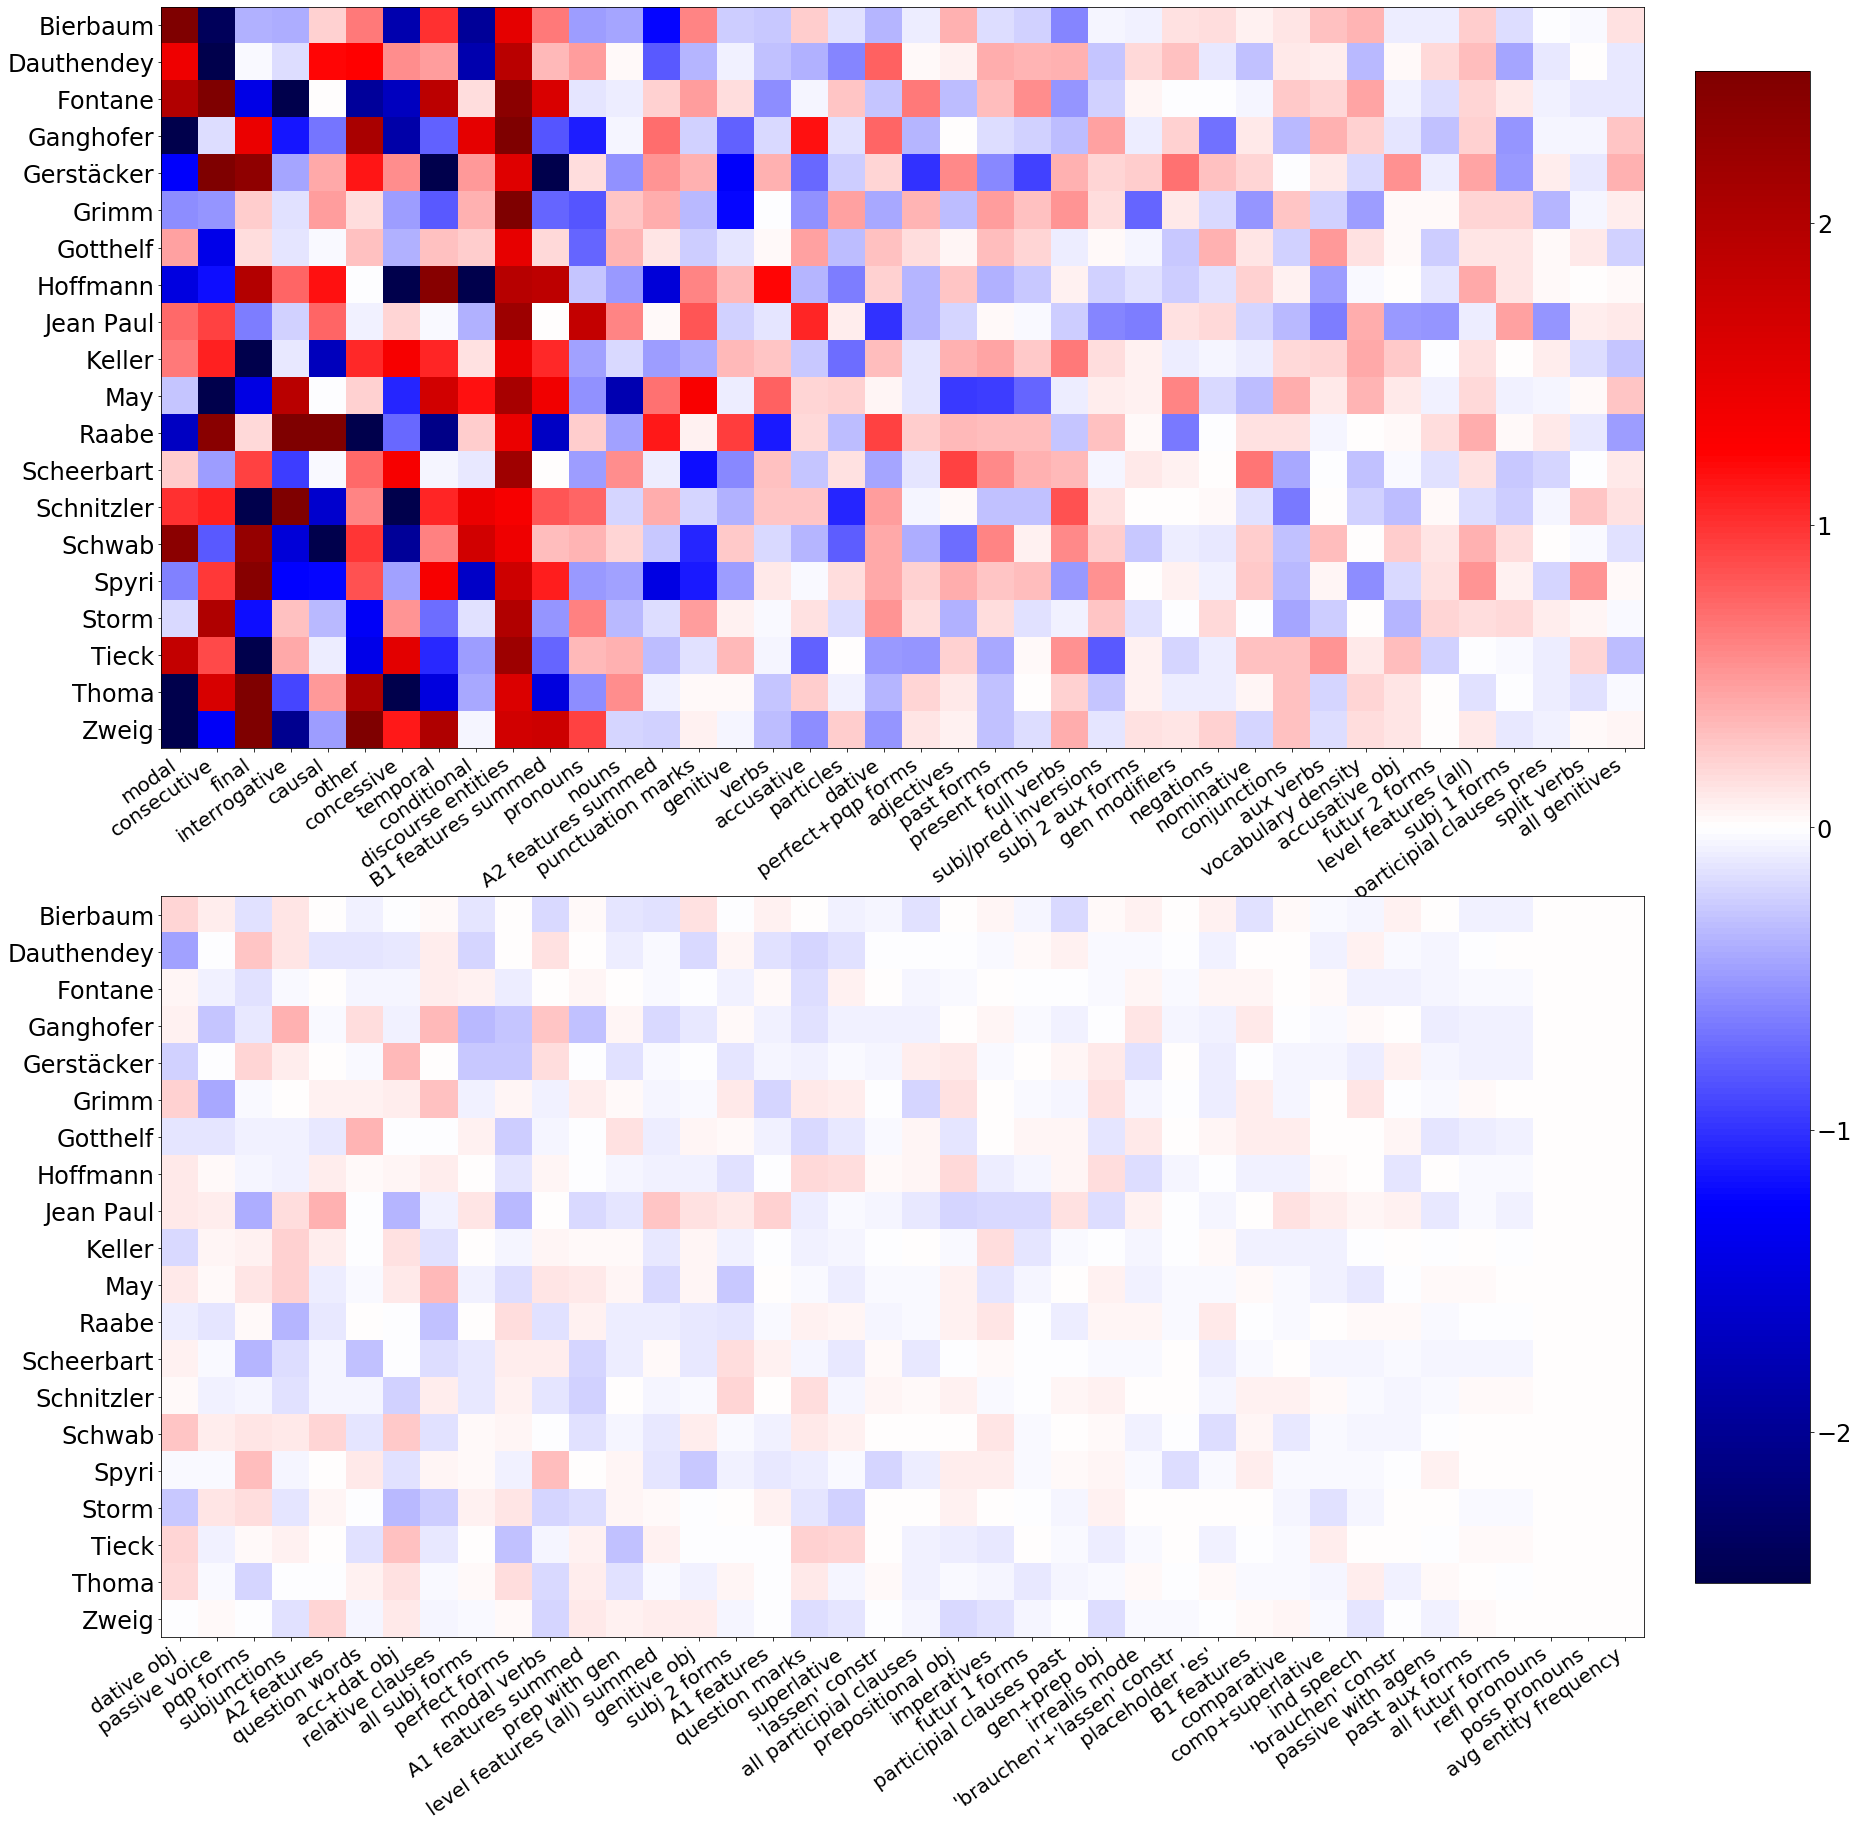

In [13]:
if not baseline:
    
    if literature_version:
        
         # sorted indices (feature with highest coefficients first)
        sort_idx = np.argsort(-abs(classifier.coef_).max(axis=0))

        # get sorted coefficients and feature names
        sorted_coef = classifier.coef_[:,sort_idx]
        sorted_fnames = feature_names[sort_idx]

        # plot feature coefficients
        x_fig, x_axis = plt.subplots(2,1,figsize=(80,30))

        im_0 = x_axis[0].imshow(sorted_coef[:,:sorted_coef.shape[1]//2], interpolation='none', cmap='seismic',vmin=-2.5, vmax=2.5)
        im_1 = x_axis[1].imshow(sorted_coef[:,sorted_coef.shape[1]//2:], interpolation='none', cmap='seismic',vmin=-2.5, vmax=2.5)

        x_axis[0].set_yticks(range(len(labels)))
        x_axis[1].set_yticks(range(len(labels)))

        x_axis[0].set_yticklabels(labels, fontsize=24)
        x_axis[1].set_yticklabels(labels, fontsize=24)

        x_axis[0].set_xticks(range(len(feature_names)//2))
        x_axis[1].set_xticks(range(len(feature_names)//2))

        x_axis[0].set_xticklabels(sorted_fnames[:len(feature_names)//2], rotation=35, ha='right', fontsize=20)
        x_axis[1].set_xticklabels(sorted_fnames[len(feature_names)//2:], rotation=35, ha='right', fontsize=20)

        x_fig.subplots_adjust(right=0.81)
        cbar_ax = x_fig.add_axes([0.605, 0.15, 0.02, 0.7])
        cbar = x_fig.colorbar(im_0, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=24) 

        #x_fig.colorbar(im_0, ax=x_axis.ravel().tolist()
        #plt.savefig('./outputs_lit/index.png',dpi=100)
        
        plt.show()
        
    else:
        

        # sorted indices (feature with highest coefficients first)
        sort_idx = np.argsort(-abs(classifier.coef_).max(axis=0))

        # get sorted coefficients and feature names
        sorted_coef = classifier.coef_[:,sort_idx]
        sorted_fnames = feature_names[sort_idx]

        # plot feature coefficients
        x_fig, x_axis = plt.subplots(2,1,figsize=(40,12))

        im_0 = x_axis[0].imshow(sorted_coef[:,:sorted_coef.shape[1]//2], interpolation='none', cmap='seismic',vmin=-2.5, vmax=2.5)
        im_1 = x_axis[1].imshow(sorted_coef[:,sorted_coef.shape[1]//2:], interpolation='none', cmap='seismic',vmin=-2.5, vmax=2.5)

        #plt.colorbar(im_1)
        #x_axis[1].set_colorbar()

        x_axis[0].set_yticks(range(len(labels)))
        x_axis[1].set_yticks(range(len(labels)))

        x_axis[0].set_yticklabels(labels, fontsize=24)
        x_axis[1].set_yticklabels(labels, fontsize=24)

        x_axis[0].set_xticks(range(len(feature_names)//2))
        x_axis[1].set_xticks(range(len(feature_names)//2))

        x_axis[0].set_xticklabels(sorted_fnames[:len(feature_names)//2], rotation=45, ha='right', fontsize=22)
        x_axis[1].set_xticklabels(sorted_fnames[len(feature_names)//2:], rotation=45, ha='right', fontsize=22)

        x_fig.subplots_adjust(right=0.61)
        cbar_ax = x_fig.add_axes([0.625, 0.15, 0.02, 0.7])
        cbar = x_fig.colorbar(im_0, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=24) 
        
        plt.show()

In [14]:
# Saving of sorted coefficients

if version == 'default' and not baseline:

    if literature_version:
            # save sorted indicies
            np.save('./outputs_lit/sorted-idx.npy',sort_idx)

            # load again
            loaded = np.load('./outputs_lit/sorted-idx.npy')
      
    else:
        
        # save sorted indicies
        np.save('./outputs/sorted-idx.npy',sort_idx)

        # load again
        loaded = np.load('./outputs/sorted-idx.npy')

### Cross Validation

In [15]:
# full, with parameter screening
if version == 'default':    
    cv_classifier = svm.LinearSVC(random_state=RANDOM_STATE, tol=0.1, C=0.6) 
    
# without parameter screening    
if version == 'default_nopara':
    cv_classifier = svm.LinearSVC(random_state=RANDOM_STATE)

# baseline
if version == 'baseline':
    cv_classifier = svm.LinearSVC(random_state=RANDOM_STATE,tol=1.0, C=2.5) 


# C-SVC (non-linear)
if version == 'non_linear_svc_rbf':
    cv_classifier = svm.SVC(random_state=RANDOM_STATE, tol=1.0, C=2.4, gamma=0.01)
    
    
# cross validation
cv_ = sklearn.model_selection.ShuffleSplit(n_splits=50, train_size=TRAIN_SIZE, 
                                           random_state=RANDOM_STATE)

accuracies = sklearn.model_selection.cross_val_score(cv_classifier, feature_array, 
                                                    solution_array, cv=cv_, 
                                                    n_jobs=5, scoring='accuracy')

precision_m = sklearn.model_selection.cross_val_score(cv_classifier, feature_array, 
                                                    solution_array, cv=cv_, 
                                                    n_jobs=5, scoring='precision_weighted')

recall_m = sklearn.model_selection.cross_val_score(cv_classifier, feature_array, 
                                                    solution_array, cv=cv_, 
                                                    n_jobs=5, scoring='recall_weighted')

f1_m = sklearn.model_selection.cross_val_score(cv_classifier, feature_array, 
                                                    solution_array, cv=cv_, 
                                                    n_jobs=5, scoring='f1_weighted')



print('\nAccuracies:')
print('Mean:',np.mean(accuracies))
print('STD: ',np.std(accuracies))

print('\nWeighted precision:')
print('Mean:',np.mean(precision_m))
print('STD: ',np.std(precision_m))

print('\nWeighted recall:')
print('Mean:',np.mean(recall_m))
print('STD: ',np.std(recall_m))

print('\nWeighted F1:')
print('Mean:',np.mean(f1_m))
print('STD: ',np.std(f1_m))


Accuracies:
Mean: 0.9788866259334691
STD:  0.003621082241166209

Weighted precision:
Mean: 0.9792112587655142
STD:  0.0035710322599773483

Weighted recall:
Mean: 0.9788866259334691
STD:  0.003621082241166209

Weighted F1:
Mean: 0.9788507469824662
STD:  0.0036479658727106962


### Parameter Screening

In [16]:
linear_para_dict = {'C':[0.1,0.5,1.0,1.5,2.0,2.5],
                    'tol':[0.0001,0.001,0.01,0.1,1,0.00001]}

nonlinear_para_dict = {'C':[0.1,0.5,1.0,1.5,2.0,2.5],
                       'tol':[0.0001,0.001,0.01,0.1,1,0.00001],
                       'gamma':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}

def linear_para_screening():
    """Parameter screening for Linear SVC"""
    
    cv_classifier = svm.LinearSVC(random_state=RANDOM_STATE)
    para_search  = sklearn.model_selection.GridSearchCV(cv_classifier, linear_para_dict, cv=cv_)
    para_search.fit(feature_array, solution_array)
    print(para_search.best_score_)
    print(para_search.best_params_)
    
def non_linear_svc_rbf_para_screening():
    """Parameter screening for C-SVC"""
    cv_classifier = svm.SVC(random_state=RANDOM_STATE)
    para_search  = sklearn.model_selection.GridSearchCV(cv_classifier, nonlinear_para_dict, cv=cv_)
    para_search.fit(feature_array, solution_array)
    print(para_search.best_score_)
    print(para_search.best_params_)

In [17]:
# Parameter screening if required
if para_screening:
    
    if version == 'non_linear_svc_rbf':
        non_linear_svc_rbf_para_screening()
    else:
        linear_para_screening()